# Starting with Tensorflow

![img](https://www.gstatic.com/devrel-devsite/prod/v870be6fb6841f3532cd3aec5bc0b3146031642f2794ae8ba7f51ebf843a655f9/tensorflow/images/lockup.svg)

[TensorFlow](https://www.tensorflow.org/) and [PyTrorch](http://pytorch.org/) are two of the most commonly used deep learning frameworks. Both of these tools are notable for their ability to compute gradients automatically and do operations on GPU, which can be by orders of magnitude faster than running on CPU. Both libraries serve the same purpose, choosing between them is a matter of preference.

In this tutorial, we'll use Tensorflow for our practical examples.

We'll start from using the low-level core of Tensorflow, and then try out some high-level features.

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.8.0


In [2]:
# numpy world

x = np.arange(16).reshape(4, 4)

print(f"X :\n{             x}")
print(f"X.shape : {        x.shape}")
print(f"add 5 :\n{         x + 5}")
print(f"X*X^T :\n{         x @ x.T}")
print(f"mean over rows :\n{x.mean(axis=-1)}")
print(f"cumsum of cols :\n{x.cumsum(axis=0)}")

X :
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
X.shape : (4, 4)
add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T :
[[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over rows :
[ 1.5  5.5  9.5 13.5]
cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [3]:
# tensorflow world

x = np.arange(16).reshape(4, 4)

x = tf.constant(x, dtype=tf.float32) 

print(f"X :\n{             x}")
print(f"X.shape : {        x.shape}")
print(f"add 5 :\n{         x + 5}")
print(f"X*X^T :\n{         x @ tf.transpose(x)}")
print(f"mean over rows :\n{tf.math.reduce_mean(x, axis=-1)}")
print(f"cumsum of cols :\n{tf.math.cumsum(x, axis=0)}")

X :
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]
X.shape : (4, 4)
add 5 :
[[ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]
 [17. 18. 19. 20.]]
X*X^T :
[[ 14.  38.  62.  86.]
 [ 38. 126. 214. 302.]
 [ 62. 214. 366. 518.]
 [ 86. 302. 518. 734.]]
mean over rows :
[ 1.5  5.5  9.5 13.5]
cumsum of cols :
[[ 0.  1.  2.  3.]
 [ 4.  6.  8. 10.]
 [12. 15. 18. 21.]
 [24. 28. 32. 36.]]


## NumPy and Tensorflow

As you can notice, tensorflow allows you to hack achieve the same numpy functionality, be it somewhat different in terms of syntax. There is an experimental feature offering exact numpy interoperability [to some extent](https://www.tensorflow.org/guide/tf_numpy#tensorflow_interoperability), but for now we'll stick with what the core `tensorflow` and `tf.math` is offering.

Note that you may easily convert tensors back to numpy:

In [99]:
x = tf.range(5, dtype=tf.float32)
tf.reduce_mean(x).numpy()

2.0

Tensor operations are subject to type checking, but conversion is not handled automatically. Try to fix the following cell so it does not trow any `TypeError`

In [100]:
x = tf.constant([1, 2], dtype=tf.int32)
x /= 2
x

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.5, 1. ])>

## Warmup: trigonometric knotwork

There are some simple mathematical functions with cool plots. For one, consider this:

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$

You have `tf.math.cos` and `tf.math.sin` at your disposal 😉

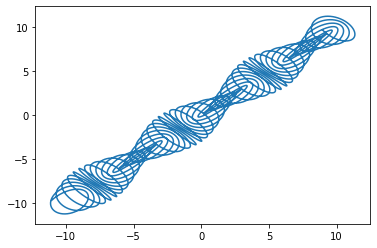

In [101]:
import matplotlib.pyplot as plt

t = tf.linspace(-10, 10, 10000)

# compute x=x(t) and y=y(t) as defined above
# your code here
#raise NotImplementedError
x = t - 1.5 * tf.math.cos(15*t) 
y = t - 1.5 * tf.math.sin(16*t) 

plt.plot(x.numpy(), y.numpy())
plt.show()

In [102]:
# Check if you plotted the intended equation
assert np.isclose(x[42].numpy(), -9.2157)
assert np.isclose(y[1990].numpy(), -4.6997)


--------

## Automatic gradients

Any self-respecting DL framework must do your *backprop* for you. Tensorflow handles this with the `tf.GradientTape` API. This means computing the gradient of a computation with respect to some inputs, usually tf.Variables. TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

The general pipeline looks like this:
* When creating a tensor, you define it either as `tf.Tensor` if you don't want it to propagate gradients or `tf.Variable` otherwise:
    * __```tf.zeros(5)```__
    * __```tf.Variable(np.arange(5), dtype=tf.float32)```__
* Define some differentiable `y = arbitrary_function(x)` inside the `tf.GradientTape` context
* Gradients are now available through `GradientTape.gradient(target, sources)`

You may read the [official guide](https://www.tensorflow.org/guide/autodiff) for more detailed explanations.

In [103]:
x = tf.Variable(0.)

with tf.GradientTape() as tape:
    y = tf.math.sin(x)
    
dy_dx = tape.gradient(y, x)
print(f"sin'(0) = {dy_dx.numpy()}")

sin'(0) = 1.0


Your turn:

In [104]:
def MSELoss(y, yhat):
    """Mean Squared Error"""
    return tf.reduce_mean((y - yhat)**2)

# initialize our target `y` and our "prediction" `yhat`
y = tf.random.normal([100], 0, 1, tf.float32)
yhat = tf.Variable(tf.random.normal([100], 0, 1, tf.float32))

#print(y)
#print(yhat)

# Calculate the mean squared error
with tf.GradientTape() as tape:
    # your code here
    loss = MSELoss(y, yhat)

# Calculate the gradient of loss w.r.t yhat
dy_dx = tape.gradient(loss,yhat)

print("Checking autograd result equals to analytical derivative.")
print("    Correct Result:", np.all(np.isclose(dy_dx.numpy(), 2 * (yhat - y) / y.shape[0])))

Checking autograd result equals to analytical derivative.
    Correct Result: True


### Learning to solve problems with gradients

We can use the gradient of our loss function to find the parameters corresponding to its minima, this is the basis of most Machine Learning algorithms.

Let's try to solve the following simple equation as an example

 $$ x^3 + 2x - 6 = 0 $$

The necessary steps are:
1. Define equation, variables and a *loss function*:

   In our case the loss function will be the Mean Squared Error as defined bellow. This will quantify how far is our prediction from the solution of the equation $$\mathcal{L}{oss} = \text{MSE}(y_\text{pred}, y_\text{true}) = ||y_\text{pred} - y_\text{true}||^2$$ 
   Where:
   - $y_\text{true} = 0$
   - $y_\text{pred} = x_\text{pred}^3 + 2x_\text{pred} - 6$
   - $x_\text{pred}$ is the solution we are checking, starting with $x_\text{pred} = 1$
2. Calculate $y_\text{pred}$ for the current value of $x_\text{pred}$ and then calculate the $\text{MSE}$ loss
3. Calculate the gradient; this is done by ` tf.GradientTape()` automatically $$\nabla\mathcal{L} = \frac{\partial \mathcal{L}{oss}}{\partial x_\text{pred}} = \frac{\partial \mathcal{L}{oss}}{\partial y_\text{pred}} \frac{\partial y_\text{pred}}{\partial x_\text{pred}}$$
4. Use $\nabla\mathcal{L}$ to find a better $x_\text{pred}$. This step usually involves a scalar hyperparameter called the *learning rate* and denoted $\eta$. 
   $$ x_\text{pred}^{(i+1)} = x_\text{pred}^{(i)} - \eta \nabla\mathcal{L}^{(i)}$$
5. We repeat this $n=$ `N_STEPS` times, iterating over the gradient-based optimization process, saving the $\text{MSE}$ and $x_\text{pred}$ after each step. Thus $i=\overline{1,n}$
   
___
#### Additional Notes: 
For some initial values of $x_\text{pred}$ the optimization process might diverge (like $x_\text{pred}=5$). Since the change in $x_\text{pred}$ is proportional to the gradient of the loss function, if the absolute value of this gradient is very large, $|x_\text{pred}|$ will get larger as well, diverging towards infinity with each step. This issue is called **exploding gradient**. You may avoid this by making the $\eta$ parameter smaller, but this will require more steps to converge.

After running the cell once, experiment with different `lr` and `N_STEPS` in order to converge to the solution when starting from $x_\text{pred}=5$.

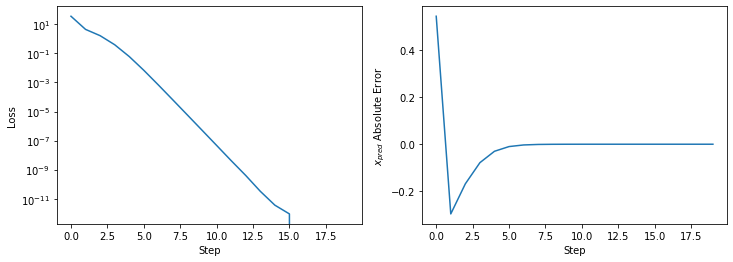

In [105]:
def equation(x):
    return x**3 + 2*x - 6

def MSELoss(y_pred, y_true):
    """Mean Squared Error"""
    return (y_pred- y_true)**2

# Define our variables
x = tf.Variable(2.0)
y_true = tf.constant(0.)

# Optimization hyperparameters
lr = 0.005
N_STEPS = 20

# Lists for intermediate result
losses = []
partial_res = []

for _ in range(N_STEPS):
    with tf.GradientTape() as tape:
        # reinitialize computational graph
        tape.watch(x) # necessary when looping

        # compute prediction and loss value
        y_pred = equation(x)
        loss = MSELoss(y_pred, y_true)
    
    # save loss and intermediary `x`
    losses.append(loss.numpy())
    partial_res.append(x.numpy())

    # get gradient and update `x`
    grad = tape.gradient(loss, x)
    x = x - lr*grad


steps = np.arange(N_STEPS)
error = np.array(partial_res) - 1.45616424613591
plt.figure(figsize=(12,4))
plt.tight_layout()
plt.subplot(1,2,1)
plt.plot(steps, losses)
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(steps, error)
plt.xlabel("Step")
plt.ylabel("$x_{pred}$ Absolute Error")
plt.show()

## Homework

Fit a linear model on the following dataset. The linear model definition and loss function are already provided. Your task is to find `a` and `b` which minimizes the loss function on the training set.

In [11]:
def linear_model(x, a, b):
    return a*x + b 

def reduce_MSE (y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [164]:
#generate data
x_train = np.arange(30)
y_train = 0.2*np.arange(30) + np.random.normal(0, 0.75, 30) - 1.0

#find the analytical solution using sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x_train.reshape((-1, 1)), y_train)

#look at the optimal model parameters and its optimal MSE loss
true_slope, true_intercept = lin_reg.coef_[0], lin_reg.intercept_
min_mse = reduce_MSE(linear_model(x_train, true_slope, true_intercept), y_train).numpy()

In [165]:
def draw_scatter(x, y, slope=None, intercept=None, ax=None):
    if ax is None:
        _,ax = plt.subplots(figsize=(6,5))
        
    ax.scatter(x, y, label='Sample Points')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Y vs X')
    
    xmin = x.min()-0.1*(x.max()-x.min())
    xmax = x.max()+0.1*(x.max()-x.min())
    ymin = y.min()-0.1*(y.max()-y.min())
    ymax = y.max()+0.1*(y.max()-y.min())
    ax.set_ylim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.set_xmargin(0)
    ax.set_ymargin(0)
    
    #ax.set_aspect((x.max()-x.min())/(y.max()-y.min()))
    
    if slope is not None and intercept is not None:
        #ax.plot(x, linear_model(x, slope, intercept), 'r-.',);
        #mse = calc_mean_sq_error(df, slope, intercept)
        ax.plot([xmin,xmax], linear_model(np.array([xmin,xmax]), slope, intercept), 'r-.', label='Fitted line');
        #ax.plot([0,0], [3,5], 'g-.',);
        y_pred = linear_model(x, slope, intercept)
        #y_pred = x_train * a + b
        mse = reduce_MSE(y_pred, y).numpy()
        eqn_str = f'a = {slope:.3f} b = {intercept:+.3f}'
        ax.set_title(f'Loss: MSE={mse:.4e}\n{eqn_str}')
        
    ax.legend(loc='upper left')
    return ax

<AxesSubplot:title={'center':'Loss: MSE=6.7514e-01\na = 0.185 b = -1.075'}, xlabel='X', ylabel='Y'>

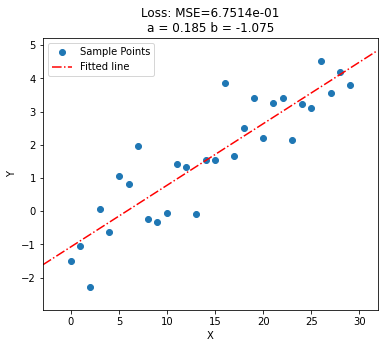

In [166]:
draw_scatter(x_train, y_train, slope=true_slope,  intercept=true_intercept)

In [167]:
def draw_progress(x, y, slope, intercept, losses, n_iter=25, fig=None, axs=None, opt=None):
    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(14,5))
    if opt:
        l = opt._name
    else:
        l = "None"    
    fig.suptitle(f'Optimizer: {l}', fontsize=20)        
    draw_scatter(x, y, slope, intercept, ax=axs[0])
    
    # Draw loss-chart.  Hardcode a few more parameters for simplicity
    xmin, xmax = 0, n_iter
    ymin, ymax = min_mse/10.0, 1000
    
    axs[1].plot(range(len(losses)), losses, 'b-', label='Computed Loss')
    axs[1].plot([xmin, xmax], [min_mse, min_mse], 'g-.', label='Minimum Possible Loss')
    axs[1].set_xlim(xmin, xmax)
    axs[1].set_ylim(ymin, ymax)
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss (MSE) (log)')
    axs[1].legend(loc='upper right')
    #axs[1].set_aspect(xmax/float(ymax))
    plt.xscale("linear")
    plt.yscale("log")

    # Update the axis titles
    #mse = calc_mean_sq_error(df, slope, intercept) if len(mse_hist)==0 else mse_hist[-1]
    
    axs[1].set_title(f'Min Loss: MSE={min_mse:.4e}\nSolution: a={true_slope:.3f} b={true_intercept:.3f}')
    #plt.tight_layout(3.0)
    
    #if file_out:
    #    fig.savefig(file_out)
        
    return fig, axs
    
#draw_progress(x_train, y_train, 0.2, -1, losses, N_STEPS)


Implement the linear model fit here:

In [168]:
losses = []
interm_a = []
interm_b = []
def run_simulation(opt=None, N_STEPS = 1000, lr = 0.001, a_start=1.0, b_start=0.0):
    # Define our variables
    a = tf.Variable(a_start, dtype=tf.float32)
    b = tf.Variable(b_start, dtype=tf.float32)
    global losses, interm_a, interm_b

    # Lists for intermediate result
    losses = []
    interm_a = []
    interm_b = []

    for i in range(N_STEPS):
        # Use persistent to allow getting multiple gradiens
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(a)
            tape.watch(b)
            y_pred = linear_model(x_train, a, b)
            #y_pred = x_train * a + b
            loss = reduce_MSE(y_pred, y_train)

        # save loss and intermediary `a` and `b`
        losses.append(loss.numpy())
        interm_b.append(b.numpy())
        interm_a.append(a.numpy())

        # get gradients and update `a` and `b`
        [grad_a, grad_b] = tape.gradient(loss, [a, b])
        if opt:
            opt.apply_gradients(zip([grad_a, grad_b], [a, b]))
        else:
            a.assign_sub(lr*grad_a)
            b.assign_sub(lr*grad_b)
            #a = a - lr*grad_a
            #b = b - lr*grad_b

        #draw_scatter(x_train, y_train, slope=a.numpy(),  intercept =  b.numpy())
        #print(grad_a.numpy(), grad_b.numpy())
        #if (i%100) == 99:
        #    draw_progress(x_train, y_train, interm_a[-1], interm_b[-1], losses, N_STEPS)
    #print(interm_a)
    #print(interm_b)
    #print(losses)
    draw_progress(x_train, y_train, interm_a[-1], interm_b[-1], losses, N_STEPS, opt=opt)

# some runs
- generate random starting values for **a** and **b**
- run the simulation with different optimizers and number of iterations

In [169]:
a = np.random.randn(); b = np.random.randn();
print(a,b)

-1.2256919835654012 0.5793788481273102


Wall time: 4.33 s


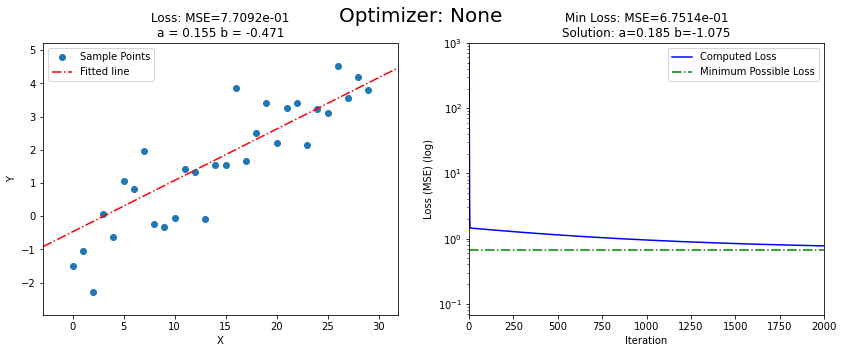

In [170]:
%%time
run_simulation(N_STEPS=2000, a_start=a, b_start=b)

Wall time: 2.79 s


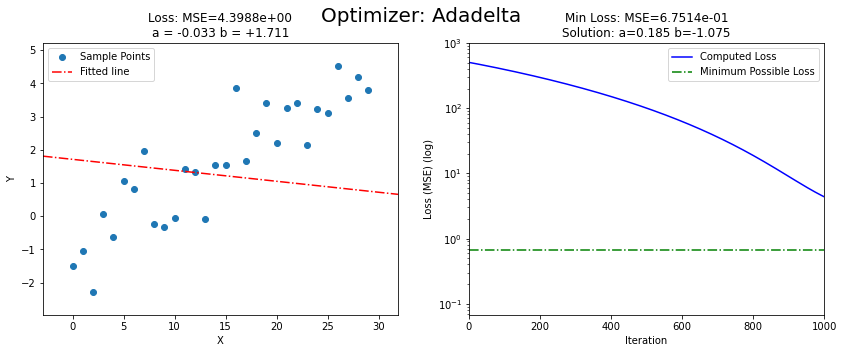

In [171]:
%%time
run_simulation(tf.optimizers.Adadelta(learning_rate=1.0, rho=0.95), N_STEPS=1000, a_start=a, b_start=b)

Wall time: 622 ms


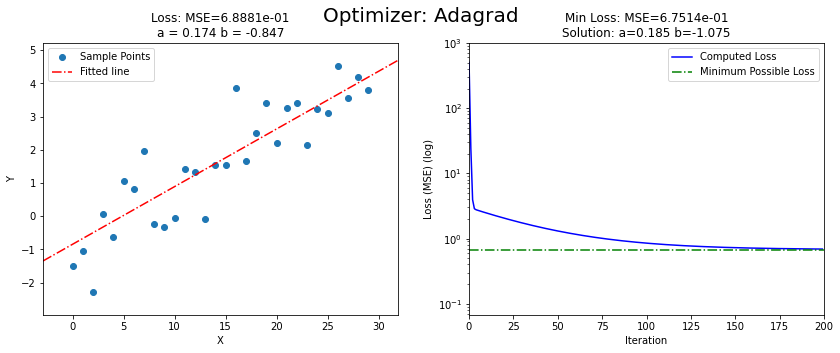

In [172]:
%%time
run_simulation(tf.optimizers.Adagrad(learning_rate=1.0), N_STEPS=200, a_start=a, b_start=b)

Wall time: 754 ms


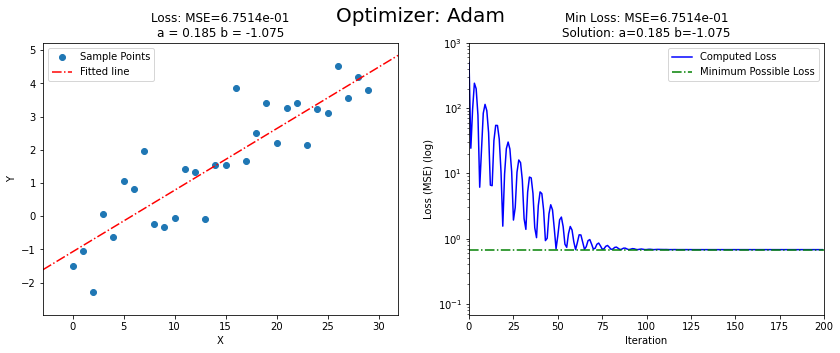

In [173]:
%%time
run_simulation(tf.optimizers.Adam(learning_rate=1.0), N_STEPS=200, a_start=a, b_start=b)

Wall time: 737 ms


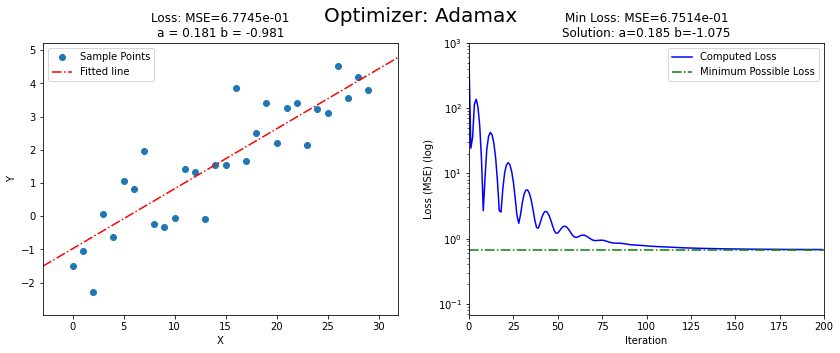

In [174]:
%%time
run_simulation(tf.optimizers.Adamax(learning_rate=1.0), N_STEPS=200, a_start=a, b_start=b)

Wall time: 750 ms


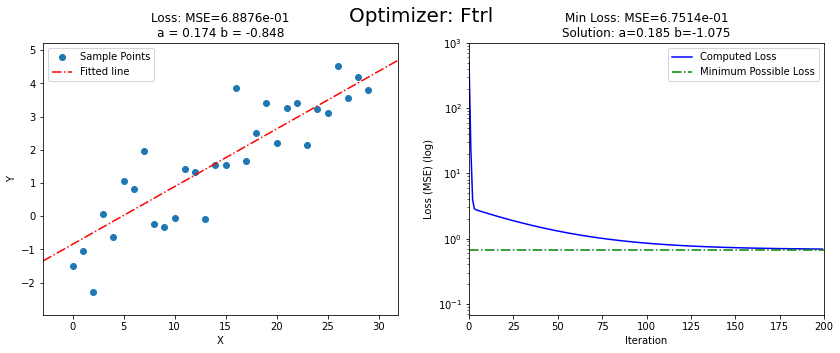

In [175]:
%%time
run_simulation(tf.optimizers.Ftrl(learning_rate=1.0), N_STEPS=200, a_start=a, b_start=b)

Wall time: 1.44 s


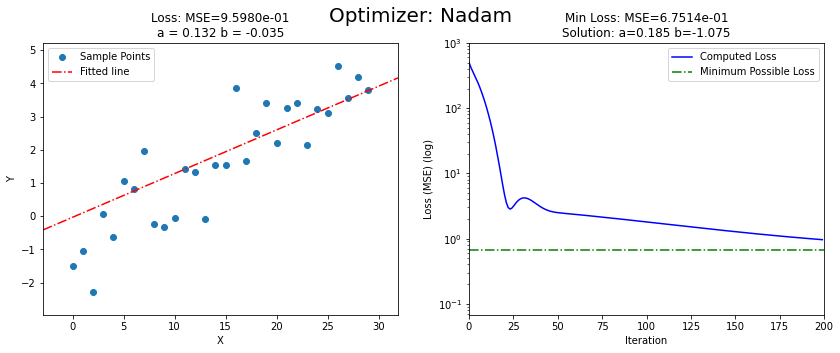

In [176]:
%%time
run_simulation(tf.optimizers.Nadam(learning_rate=0.1), N_STEPS=200, a_start=a, b_start=b)

Wall time: 651 ms


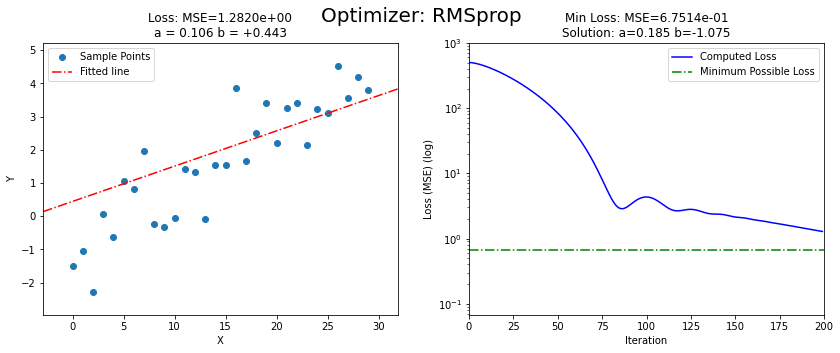

In [177]:
%%time
run_simulation(tf.optimizers.RMSprop(momentum=0.95), N_STEPS=200, a_start=a, b_start=b)

Wall time: 600 ms


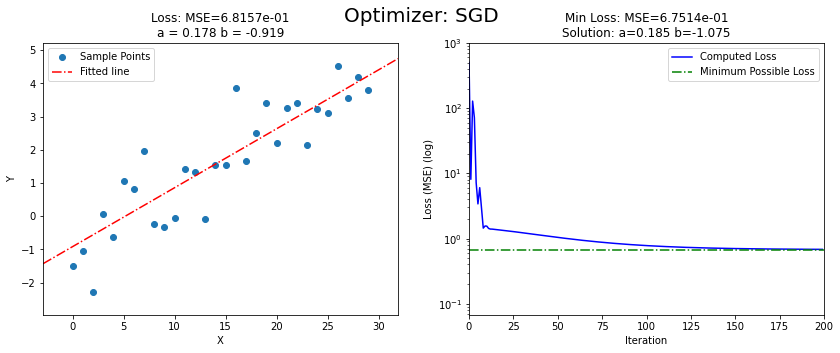

In [178]:
%%time
run_simulation(tf.optimizers.SGD(learning_rate=0.001,momentum=0.95,nesterov=True), N_STEPS=200, a_start=a, b_start=b)

## Animation

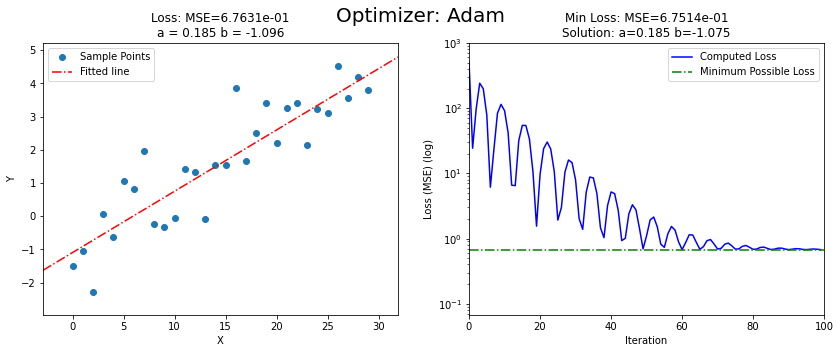

In [202]:
run_simulation(tf.optimizers.Adam(learning_rate=1.0), N_STEPS=100, a_start=a, b_start=b)

In [203]:
#np.shape(losses)
#np.shape(interm_a)
#np.shape(interm_b)

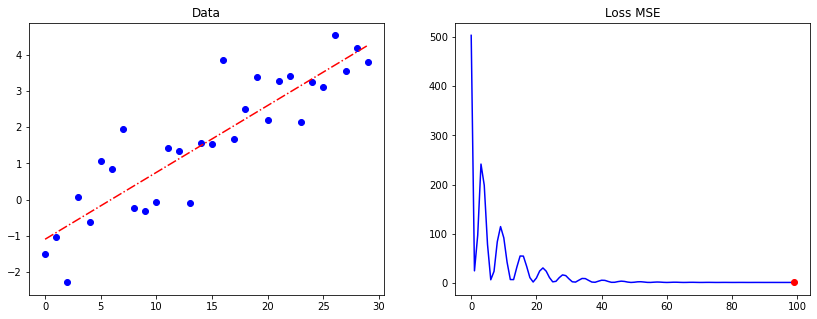

In [204]:
%matplotlib inline
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, axs = plt.subplots(1, 2, figsize=(14,5))
ln, = axs[0].plot(x_train, y_train, 'bo')
axs[0].set_title('Data')
axs[1].set_title('Loss MSE')
ln2, = axs[0].plot([], [], 'r-.')
ln3, = axs[1].plot(range(len(losses)), losses, 'b-', label='Computed Loss')
ln4, = axs[1].plot([], [], 'ro')

def init():
    #ax.set_xlim(0, 2*np.pi)
    #ax.set_ylim(-1, 1)
    #ln2, = plt.plot(x_train, y_train, 'go')

    return ln2,

def update(frame):
    #xdata.append(frame)
    #ydata.append(np.sin(frame))
    ln2.set_data(x_train, linear_model(x_train, interm_a[frame], interm_b[frame]))
    ln4.set_data([frame], losses[frame])
    return ln2,

anim = FuncAnimation(fig, update, frames=np.arange(0, len(losses)),
                    init_func=init, blit=False, interval=50)
HTML(anim.to_jshtml())